In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
class Environment: 
    #interact with the learner by returning stochastic reward
    # depending of the pulled arm
    def __init__(self, n_arms, probabilities):
        # defined by the nb of arms and 
        # proba distribution of arms rewards
        self.n_arms = n_arms
        self.probabilities = probabilities
    
    def round(self, pulled_arm):
        # we suppose here that the probDistribution of reward is binomial
        # 1 because we are in a bernoulli
        reward = np.random.binomial(1,self.probabilities[pulled_arm])
        return reward
    

In [15]:
class learner:
    #interact with environement by selecting the arm to pull
    # and observe reward given by the environement
    def __init__(self, n_arms):
        # defined by nb arms, current round and the collected rewards
        self.n_arms = n_arms
        self.t=0
        self.reward_per_arm = x = [[] for _ in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.reward_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)


In [16]:
class TS_Learner(learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        # store beta distribution
        self.beta_parameters = np.ones((n_arms,2))

    def pull_arm(self):
        #select the best arm
        idx = np.argmax(np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1]))
        return idx

    def update(self, pulled_arm, reward):
        #updtate his parameters
        self.t+=1
        self.update_observations(pulled_arm,reward)
        self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0]+reward # count how many succes we have
        self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1]+1-reward # count the opposit

In [17]:
class GreadyLearner(learner): 
    # in order to compare with the TS learner
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.expected_rewards = np.zeros(n_arms)

    def pull_arm(self):
        if(self.t<self.n_arms):
            return self.t # assure to select each arms at first
        #select the maximizer arms
        idxs = np.argwhere(self.expected_rewards == self.expected_rewards.max()).reshape(-1)
        #compute a choice randomly between the best
        pulled_arm = np.random.choice(idxs)
        return pulled_arm

    def update(self, pulled_arm, reward):
        self.t+=1
        self.update_observations(pulled_arm, reward)
        self.expected_rewards[pulled_arm] = (self.expected_rewards[pulled_arm]*(self.t-1)+reward)/self.t
        

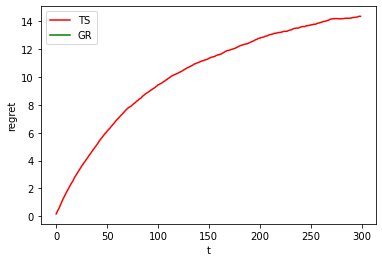

In [20]:
n_arms = 4
p = np.array([0.15,0.1,0.1,0.35])
opt = p[3]

T = 300

n_experiments = 1000
ts_rewards_per_experiment = []
gr_rewards_per_experiment = []


for e in range(0, n_experiments):
    env = Environment (n_arms=n_arms, probabilities = p)
    ts_learner = TS_Learner(n_arms=n_arms)
    gr_learner = GreadyLearner(n_arms=n_arms)

    for t in range(0, T):
    #Thompson Sampling learner
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)
    
    #Greedy learning
        pulled_arm = gr_learner.pull_arm()
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)


plt.figure(0)
plt.xlabel("t")
plt.ylabel("regret")
plt.plot(np.cumsum(np.mean(opt-ts_rewards_per_experiment,axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt-gr_rewards_per_experiment,axis=0)), 'g')
plt.legend(["TS", "GR"])
plt.show()

